In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from secrets import *

In [2]:
league_id = 84057

In [ ]:
swid = 


In [3]:
url = 'https://fantasy.espn.com/apis/v3/games/FBA/seasons/2020/segments/0/leagues/' + str(league_id)
params={"view": "kona_player_info"}
cookies = {"swid": AUTH['swid'],
           "espn_s2": AUTH['espn_s2']}
r = requests.get(url, params=params, cookies=cookies)
data = r.json()
data.keys()

dict_keys(['players'])

In [4]:
stat_list = []
for player in data['players']:
    #print(player['player']['fullName'])
    for stat_item in player['player']['stats']:
        #looks like season totals AND averages id = '002020'
        if stat_item['id'] == '002020':
            if '40' in stat_item['stats'].keys(): # '40' is minutes
                stat_item['stats']['playerName'] = player['player']['fullName']
                stat_list.append(stat_item['stats'])

In [5]:
stats_df = pd.DataFrame(stat_list)
stats_df.shape

(457, 45)

In [6]:
col_rename_dict = {'0':'pts', '1':'blocks', '2':'steals', '3':'ast', '6':'reb', '13':'fgm', '14': 'fga', 
                   '15': 'ftm', '16':'fta', '17':'threes', '40':'min', '42':'gp'}
stats_df.rename(columns=col_rename_dict, inplace=True)
stats_df['fg_pct'] = stats_df['fgm'] / stats_df['fga']
stats_df['ft_pct'] = stats_df['ftm'] / stats_df['fta']
stats_df = stats_df[['playerName','pts','blocks','steals','ast','reb','fgm','fga','fg_pct','ftm','fta','ft_pct','threes','min','gp']]

In [7]:
stats_df.head()

,playerName,pts,blocks,steals,ast,reb,fgm,fga,fg_pct,ftm,fta,ft_pct,threes,min,gp
0,Vince Carter,150.0,10.0,8.0,30.0,58.0,54.0,160.0,0.337500,12.0,17.0,0.705882,30.0,457.0,29.0
1,Tyson Chandler,34.0,8.0,6.0,6.0,61.0,14.0,18.0,0.777778,6.0,13.0,0.461538,0.0,194.0,22.0
2,LeBron James,873.0,19.0,45.0,385.0,275.0,336.0,691.0,0.486252,130.0,192.0,0.677083,71.0,1229.0,35.0
3,Carmelo Anthony,351.0,15.0,23.0,28.0,132.0,133.0,312.0,0.426282,53.0,66.0,0.803030,32.0,698.0,22.0
4,Kyle Korver,207.0,7.0,15.0,40.0,60.0,67.0,159.0,0.421384,18.0,21.0,0.857143,55.0,537.0,32.0


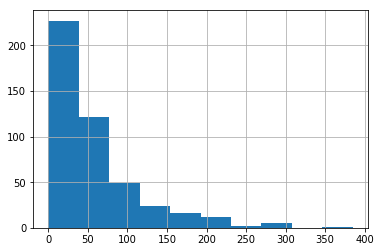

In [8]:
stats_df['ast'].hist()

In [9]:
stats_df.loc[:,'ast_rank'] = stats_df.apply(lambda x: ( (x['ast'] - stats_df['ast'].mean()) / stats_df['ast'].std()) , axis = 1)
stats_df.loc[:,'blocks_rank'] = stats_df.apply(lambda x: ( (x['blocks'] - stats_df['blocks'].mean()) / stats_df['blocks'].std()) , axis = 1)
stats_df.loc[:,'steals_rank'] = stats_df.apply(lambda x: ( (x['steals'] - stats_df['steals'].mean()) / stats_df['steals'].std()) , axis = 1)
stats_df.loc[:,'reb_rank'] = stats_df.apply(lambda x: ( (x['reb'] - stats_df['reb'].mean()) / stats_df['reb'].std()) , axis = 1)
stats_df.loc[:,'pts_rank'] = stats_df.apply(lambda x: ( (x['pts'] - stats_df['pts'].mean()) / stats_df['pts'].std()) , axis = 1)
stats_df.loc[:,'threes_rank'] = stats_df.apply(lambda x: ( (x['threes'] - stats_df['threes'].mean()) / stats_df['threes'].std()) , axis = 1)
stats_df.loc[:,'fta_rank'] = stats_df.apply(lambda x: ( (x['fta'] - stats_df['fta'].mean()) / stats_df['fta'].std()) , axis = 1)
stats_df.loc[:,'fga_rank'] = stats_df.apply(lambda x: ( (x['fga'] - stats_df['fga'].mean()) / stats_df['fga'].std()) , axis = 1)
stats_df.loc[:,'ft_pct_rank'] = stats_df.apply(lambda x: ( (x['ft_pct'] - stats_df['ft_pct'].mean()) / stats_df['ft_pct'].std()) , axis = 1)
stats_df.loc[:,'fg_pct_rank'] = stats_df.apply(lambda x: ( (x['fg_pct'] - stats_df['fg_pct'].mean()) / stats_df['fg_pct'].std()) , axis = 1)
stats_df['fg_rank_adj'] = stats_df['fg_pct_rank'] * stats_df['fga_rank']
stats_df['ft_rank_adj'] = stats_df['ft_pct_rank'] * stats_df['fta_rank']

cat_ranks = ['ast_rank','blocks_rank','steals_rank','reb_rank','pts_rank','threes_rank','fg_rank_adj','ft_rank_adj']
stats_df['total_rank'] = stats_df[cat_ranks].sum(axis=1)
stats_df.sort_values('total_rank', inplace=True, ascending= False)

final_stats_df = stats_df[['playerName','total_rank'] + cat_ranks]

In [10]:
# how to properly account for fga and fta in their ranks? Did what I did make sense?
# do I need to remove anyone when I calculate the ranks?

In [11]:
final_stats_df.loc[stats_df.playerName == 'Julius Randle']

,playerName,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
249,Julius Randle,5.462817,1.030858,-0.346322,0.609221,2.429572,1.814059,0.514221,0.099583,-0.688374


In [12]:
final_stats_df.loc[stats_df.playerName == 'Ja Morant']

,playerName,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
433,Ja Morant,5.247267,2.470666,-0.205763,0.812146,-0.092914,1.268849,0.032947,0.332043,0.629293


In [13]:
final_stats_df.loc[stats_df.playerName == 'T.J. Warren']

,playerName,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
188,T.J. Warren,5.281208,-0.157821,0.215913,1.217997,0.3275,1.694379,0.617351,0.840523,0.525366


In [14]:
final_stats_df.loc[stats_df.playerName == 'Tomas Satoransky']

,playerName,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
119,Tomas Satoransky,5.523063,2.236279,-0.486881,2.367909,0.305373,0.45325,0.514221,0.029846,0.103067
